In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPUs:", gpus)
    except RuntimeError as e:
        print("Error initializing GPUs:", e)
else:
    print("No GPUs available.")


Using GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.layers import ZeroPadding2D, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from glob import glob
import time

In [5]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer='ones',
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.scale * normalized + self.offset

AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 256
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1
    return image

def create_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, 
                         num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    
    if apply_norm:
        result.add(InstanceNormalization())
    
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    
    if apply_dropout:
        result.add(Dropout(0.5))
    
    result.add(ReLU())
    return result

def Generator():
    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    # Downsampling
    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]
    
    # Upsampling
    up_stack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                          kernel_initializer=initializer,
                          activation='tanh')
    
    x = inputs
    skips = []
    
    # Encoder
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    return Model(inputs=inputs, outputs=x)


In [6]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    
    x = inp
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1,
                 kernel_initializer=initializer,
                 use_bias=False)(zero_pad1)
    
    norm1 = InstanceNormalization()(conv)
    leaky_relu = LeakyReLU()(norm1)
    
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1,
                 kernel_initializer=initializer)(zero_pad2)
    
    return Model(inputs=inp, outputs=last)

In [7]:
class CycleGAN(Model):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.gen_G = Generator()
        self.gen_F = Generator()
        self.disc_X = Discriminator()
        self.disc_Y = Discriminator()
        
        self.lambda_cycle = 10.0
        self.lambda_identity = 0.5 * self.lambda_cycle
        
        self.gen_G_optimizer = Adam(2e-4, beta_1=0.5)
        self.gen_F_optimizer = Adam(2e-4, beta_1=0.5)
        self.disc_X_optimizer = Adam(2e-4, beta_1=0.5)
        self.disc_Y_optimizer = Adam(2e-4, beta_1=0.5)
    
    @tf.function
    def train_step(self, batch_data):
        real_x, real_y = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            # Generator F translates Y -> X
            
            fake_y = self.gen_G(real_x, training=True)
            cycled_x = self.gen_F(fake_y, training=True)

            fake_x = self.gen_F(real_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Same image should be generated when using identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator outputs
            disc_real_x = self.disc_X(real_x, training=True)
            disc_real_y = self.disc_Y(real_y, training=True)
            
            disc_fake_x = self.disc_X(fake_x, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator losses
            gen_G_loss = self.generator_loss(disc_fake_y)
            gen_F_loss = self.generator_loss(disc_fake_x)
            
            cycle_loss_G = self.cycle_loss(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss(real_x, cycled_x) * self.lambda_cycle
            
            id_loss_G = self.identity_loss(real_y, same_y) * self.lambda_identity
            id_loss_F = self.identity_loss(real_x, same_x) * self.lambda_identity

            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            disc_X_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)

        generator_G_gradients = tape.gradient(total_loss_G,
                                            self.gen_G.trainable_variables)
        generator_F_gradients = tape.gradient(total_loss_F,
                                            self.gen_F.trainable_variables)
        
        discriminator_X_gradients = tape.gradient(disc_X_loss,
                                                self.disc_X.trainable_variables)
        discriminator_Y_gradients = tape.gradient(disc_Y_loss,
                                                self.disc_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(
            zip(generator_G_gradients, self.gen_G.trainable_variables))
        
        self.gen_F_optimizer.apply_gradients(
            zip(generator_F_gradients, self.gen_F.trainable_variables))
        
        self.disc_X_optimizer.apply_gradients(
            zip(discriminator_X_gradients, self.disc_X.trainable_variables))
        
        self.disc_Y_optimizer.apply_gradients(
            zip(discriminator_Y_gradients, self.disc_Y.trainable_variables))
        
        return {
            'G_loss': total_loss_G,
            'F_loss': total_loss_F,
            'D_X_loss': disc_X_loss,
            'D_Y_loss': disc_Y_loss
        }

    def generator_loss(self, generated_output):
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(
            tf.ones_like(generated_output), generated_output, from_logits=True))

    def discriminator_loss(self, real_output, generated_output):
        real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(
            tf.ones_like(real_output), real_output, from_logits=True))
        
        generated_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(
            tf.zeros_like(generated_output), generated_output, from_logits=True))
        
        return (real_loss + generated_loss) * 0.5

    def cycle_loss(self, real_image, cycled_image):
        return tf.reduce_mean(tf.abs(real_image - cycled_image))

    def identity_loss(self, real_image, same_image):
        return tf.reduce_mean(tf.abs(real_image - same_image))

In [10]:
def train_cyclegan(cyclegan, dataset_a, dataset_b, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for batch_a, batch_b in tf.data.Dataset.zip((dataset_a, dataset_b)):
            cyclegan.train_step((batch_a, batch_b))
        
        if (epoch + 1) % 5 == 0:
            cyclegan.gen_G.save(f'generator_G_epoch_{epoch+1}.keras')
            cyclegan.gen_F.save(f'generator_F_epoch_{epoch+1}.keras')
            
        print(f'Epoch {epoch + 1} completed')
        print(f'Time taken: {time.time() - start} seconds')

if __name__ == "__main__":
    train_a_paths = glob('/kaggle/input/faces-dataset-small/faces_dataset_small/00055.png')
    train_b_paths = glob('/kaggle/input/faces-dataset-small/faces_dataset_small/00245.png')
    
    train_a = create_dataset(train_a_paths)
    train_b = create_dataset(train_b_paths)
    
    cyclegan = CycleGAN()
    train_cyclegan(cyclegan, train_a, train_b, epochs=40)
    
    cyclegan.gen_G.save('generator_G_final.keras')
    cyclegan.gen_F.save('generator_F_final.keras')
    cyclegan.disc_X.save('discriminator_X_final.keras')
    cyclegan.disc_Y.save('discriminator_Y_final.keras')


2024-11-02 05:23:51.267985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_36_1/sequential_24_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 completed
Time taken: 16.152389764785767 seconds
Epoch 2 completed
Time taken: 0.20302557945251465 seconds
Epoch 3 completed
Time taken: 0.2015998363494873 seconds
Epoch 4 completed
Time taken: 0.19230365753173828 seconds
Epoch 5 completed
Time taken: 0.48997950553894043 seconds
Epoch 6 completed
Time taken: 0.1915881633758545 seconds
Epoch 7 completed
Time taken: 0.1935422420501709 seconds
Epoch 8 completed
Time taken: 0.19276905059814453 seconds
Epoch 9 completed
Time taken: 0.19350647926330566 seconds
Epoch 10 completed
Time taken: 0.4863913059234619 seconds
Epoch 11 completed
Time taken: 0.19112753868103027 seconds
Epoch 12 completed
Time taken: 0.19588279724121094 seconds
Epoch 13 completed
Time taken: 0.19182300567626953 seconds
Epoch 14 completed
Time taken: 0.1936800479888916 seconds
Epoch 15 completed
Time taken: 0.4875061511993408 seconds
Epoch 16 completed
Time taken: 0.19197893142700195 seconds
Epoch 17 completed
Time taken: 0.19444656372070312 seconds
Epoch 18 comp

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


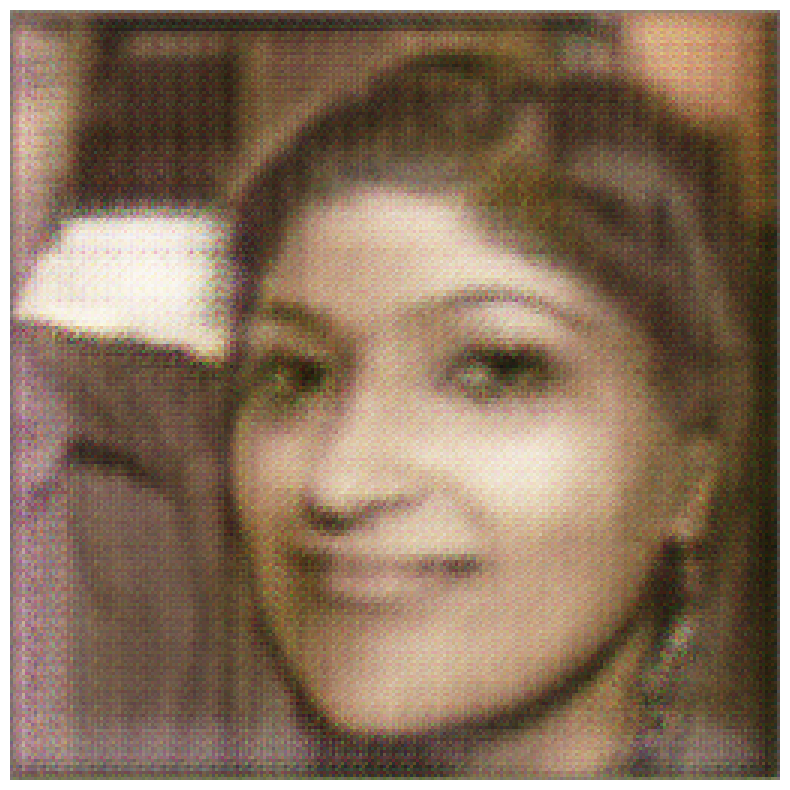

In [14]:
import tensorflow as tf
import numpy as np
from PIL import Image
import io
import base64
from IPython.display import HTML
import matplotlib.pyplot as plt

@tf.keras.utils.register_keras_serializable()
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer='ones', trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros', trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.scale * normalized + self.offset

    def get_config(self):
        config = super(InstanceNormalization, self).get_config()
        config.update({'epsilon': self.epsilon})
        return config

def load_and_preprocess_image(image_path, size=(256, 256)):
    img = Image.open(image_path).resize(size)
    img = (np.array(img).astype(np.float32) - 127.5) / 127.5
    return np.expand_dims(img, axis=0)

def postprocess_image(img):
    img = ((img + 1) * 127.5).astype(np.uint8)
    return np.squeeze(img, axis=0)

def create_download_link(img_array, filename='transformed_image.jpg'):
    img = Image.fromarray(img_array)
    buf = io.BytesIO()
    img.save(buf, format='JPEG')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode()
    href = f'<a href="data:image/jpeg;base64,{img_str}" download="{filename}">Download Transformed Image</a>'
    return HTML(href)

def display_and_download_image(img_array, filename='transformed_image.jpg'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    return create_download_link(img_array, filename)

def transform_image(input_path, model_path, style='AtoB'):
    model = tf.keras.models.load_model(model_path, custom_objects={'InstanceNormalization': InstanceNormalization}, compile=False)
    input_img = load_and_preprocess_image(input_path)
    generated_img = model.predict(input_img)
    transformed_img = postprocess_image(generated_img)
    return transformed_img

if __name__ == "__main__":
    input_image = "/kaggle/input/faces-dataset-small/faces_dataset_small/00237.png"
    model_path = "/kaggle/working/generator_G_final.keras"
    transformed_img = transform_image(input_image, model_path)
    display_and_download_image(transformed_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


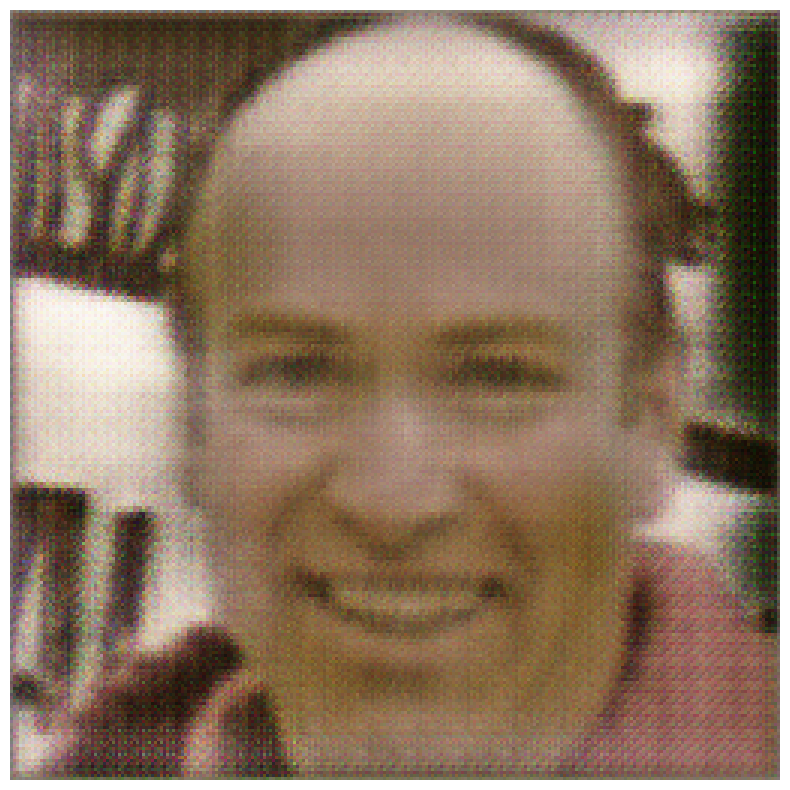

In [15]:
if __name__ == "__main__":
    input_image = "/kaggle/input/faces-dataset-small/faces_dataset_small/00267.png"
    model_path = "/kaggle/working/generator_G_final.keras"
    transformed_img = transform_image(input_image, model_path)
    display_and_download_image(transformed_img)
